# Collaborative Production

This is the script for the numerical experiment in the paper ...

## Install **pdra** package:
Ensure you have set up a git environment, and then run

In [3]:
%pip install "pdra[exp] @ git+https://github.com/rui-huang-opt/pdra.git"

  Cloning https://github.com/rui-huang-opt/pdra.git to /tmp/pip-install-3171nxe3/pdra_5639c4bd3c644ec289d8cc402e041646
  Running command git clone --filter=blob:none --quiet https://github.com/rui-huang-opt/pdra.git /tmp/pip-install-3171nxe3/pdra_5639c4bd3c644ec289d8cc402e041646
  Resolved https://github.com/rui-huang-opt/pdra.git to commit 0a3fe5a9edcaeba2d93064fde434045f8b9af845
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/rui-huang-opt/gossip.git to /tmp/pip-install-3171nxe3/gossip_38c902e1737e416f886cc64a7c1c69f7
  Running command git clone --filter=blob:none --quiet https://github.com/rui-huang-opt/gossip.git /tmp/pip-install-3171nxe3/gossip_38c902e1737e416f886cc64a7c1c69f7
  Resolved https://github.com/rui-huang-opt/gossip.git to commit cc26e514d3b2c0e0a710e449d39455825077cba2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done

## Set some important directories path (**compulsory**):

In [2]:
import os

script_dir = os.getcwd()
data_dir = os.path.join(script_dir, "data", "cp")
figure_dir = os.path.join(script_dir, "figures", "cp")
results_dir = os.path.join(script_dir, "results", "cp")

## Communication topology (**compulsory**):

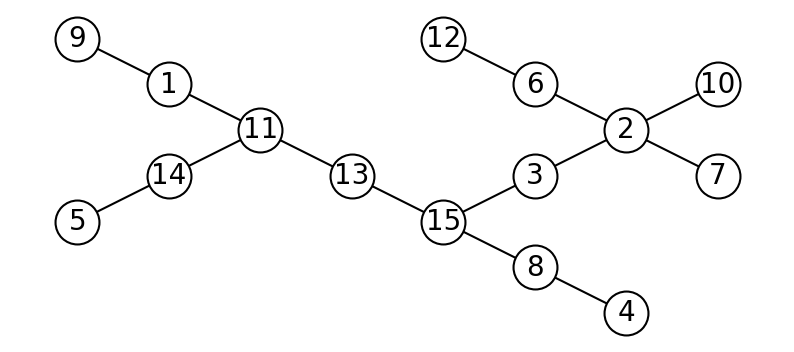

In [3]:
node_names = [f"{i}" for i in range(1, 16)]
edge_pairs = [
    ("1", "9"),
    ("1", "11"),
    ("2", "3"),
    ("2", "6"),
    ("2", "7"),
    ("2", "10"),
    ("6", "12"),
    ("3", "15"),
    ("4", "8"),
    ("5", "14"),
    ("8", "15"),
    ("11", "13"),
    ("11", "14"),
    ("13", "15"),
]

import matplotlib.pyplot as plt
import networkx as nx

plt.rcdefaults()

graph = nx.Graph()
graph.add_nodes_from(node_names)
graph.add_edges_from(edge_pairs)

fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_aspect(1)

nx_options = {
    "with_labels": True,
    "font_size": 20,
    "node_color": "white",
    "node_size": 1000,
    "edgecolors": "black",
    "linewidths": 1.5,
    "width": 1.5,
    "pos": {
        "1": [-3.0, 1.5],
        "2": [2.0, 1.0],
        "3": [1.0, 0.5],
        "4": [2.0, -1.0],
        "5": [-4.0, 0.0],
        "6": [1.0, 1.5],
        "7": [3.0, 0.5],
        "8": [1.0, -0.5],
        "9": [-4.0, 2.0],
        "10": [3.0, 1.5],
        "11": [-2.0, 1.0],
        "12": [0.0, 2.0],
        "13": [-1.0, 0.5],
        "14": [-3.0, 0.5],
        "15": [0.0, 0.0],
    },
}

nx.draw(graph, ax=ax1, **nx_options)

plt.show()

## Problem formulation:
$$
\begin{split}
    \min_{\boldsymbol{x}_{1}, \ldots, \boldsymbol{x}_{9}} \quad &\sum_{i \in \mathcal{I}}\left( \frac{1}{2}\boldsymbol{x}_{i}^{\top}Q_{i}\boldsymbol{x}_{i} + \boldsymbol{g}_{i}^{\top}\boldsymbol{x}_{i} \right)\\
    \text{s.t.} \quad
    &\begin{cases}
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 1}^{\top}\boldsymbol{x}_{i} \leq b_{1}(D) \\
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 2}^{\top}\boldsymbol{x}_{i} \leq b_{2}(D) \\
        \sum_{i \in \mathcal{I}}\boldsymbol{a}_{i, 3}^{\top}\boldsymbol{x}_{i} \leq b_{3}(D)
    \end{cases}
\end{split}
$$

### Load data (**compulsory**):

In [4]:
import os
import numpy as np
from typing import Dict
from numpy.typing import NDArray

c_pro: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "c_pro.npz"))
A_mat: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "A_mat.npz"))
x_lab: Dict[str, NDArray[np.float64]] = np.load(os.path.join(data_dir, "x_lab.npz"))

b_mat: NDArray[np.float64] = np.load(os.path.join(data_dir, "b_mat.npy"))

### Run centralized optimization (**compulsory**):

In [ ]:
import cvxpy as cp

x = {i: cp.Variable(A_mat[i].shape[1]) for i in node_names}

cost = cp.sum([-c_pro[i] @ x[i] for i in node_names])

lab_constraints: list[cp.Constraint] = [x[i] - x_lab[i] <= 0 for i in node_names]
mat_constraints: list[cp.Constraint] = [
    sum([A_mat[i] @ x[i] for i in node_names], start=cp.Constant(0)) - b_mat <= 0
]

constraints = mat_constraints + lab_constraints

problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve(solver="GLPK")

opt_val: np.float64 = problem.value  # type: ignore

print(f"Optimal value: {opt_val}")

Optimal value: -62.837151677467475


### Run distributed optimization (**compulsory**):

In [12]:
if __name__ == "__main__":
    from functools import partial
    from pdra import Node, TruncatedLaplace
    from gossip import create_sync_network

    node_params = {
        "max_iter": 3000,
        "step_size": 10.0,
        "method": "SM",
        "solver": "GLPK",
        "results_prefix": results_dir,
    }

    epsilon = 0.5
    delta = 0.005
    Delta = 0.1

    s = (Delta / epsilon) * np.log(b_mat.size * (np.exp(epsilon) - 1) / delta + 1)
    tl = TruncatedLaplace(-s, s, 0, Delta / epsilon)
    b_mat_bar = b_mat - s * np.ones(b_mat.size) + tl.sample(b_mat.size)

    """
    Distributed resource allocation
    """
    def f(x_i: cp.Variable, index: str) -> cp.Expression:
        return -c_pro[index] @ x_i

    def g(x_i: cp.Variable, index: str) -> cp.Expression:
        return x_i - x_lab[index]

    gossip_network = create_sync_network(node_names, edge_pairs)
    nodes = [
        Node.create(
            "core",
            gossip_network[i],
            partial(f, index=i),
            A_mat[i],
            partial(g, index=i),
            **node_params,
        )
        for i in node_names
    ]
    nodes[0].set_resource(b_mat_bar)

    for node in nodes:
        node.start()

    for node in nodes:
        node.join()

## Set up latex options for matplotlib (**compulsory**):

In [17]:
import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = "\\usepackage{amsmath}"
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 15

## Results plot:
- Load results:

In [13]:
iterations = np.arange(1, node_params["max_iter"] + 1)

results = {i: np.load(os.path.join(results_dir, f"node_{i}.npz")) for i in node_names}

- Error evolution:

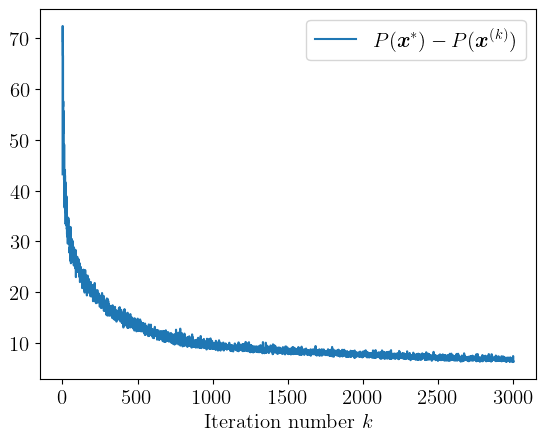

In [18]:
from matplotlib.ticker import MultipleLocator

fig2, ax2 = plt.subplots()

f_i_series = {i: results[i]["f_i_series"] for i in node_names}
err_series = sum(f_i_series.values()) - opt_val

ax2.step(
    iterations,
    err_series,
    label=r"$P(\boldsymbol{x}^*)-P(\boldsymbol{x}^{(k)})$",
)

ax2.set_xlabel("Iteration number $k$")
ax2.yaxis.set_major_locator(MultipleLocator(10))
ax2.legend()

plt.show()

- Constraints violation:

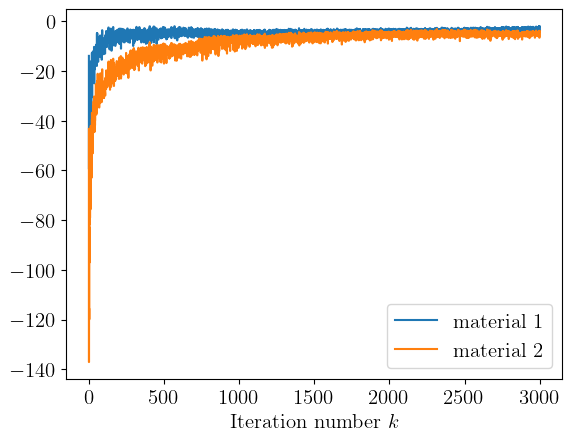

In [19]:
fig3, ax3 = plt.subplots()
x_series: Dict[str, NDArray[np.float64]] = {
    i: results[i]["x_i_series"] for i in node_names
}

constraint_values: NDArray[np.float64] = (
    sum([A_mat[i] @ x_series[i] for i in node_names]) - b_mat[:, np.newaxis]
)

for i in range(constraint_values.shape[0]):
    ax3.step(iterations, constraint_values[i], label=f"material {i + 1}")

ax3.set_xlabel("Iteration number $k$")
ax3.legend()

plt.show()

## Save the figures:

In [ ]:
fig1.savefig(os.path.join(figure_dir, "fig_1.pdf"), format="pdf", bbox_inches="tight")
fig2.savefig(os.path.join(figure_dir, "fig_2.pdf"), format="pdf", bbox_inches="tight")
fig3.savefig(os.path.join(figure_dir, "fig_3.pdf"), format="pdf", bbox_inches="tight")